In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# read in data
ligands = pd.read_csv("../data/ligands.txt", header=None)
potential_receptors = pd.read_csv("../data/receptors.txt", header=None)
cell_surf_prot_sheet = pd.read_excel("../subcel_location/cell_surface_atlas.xlsx", sheet_name="Table B")
cell_surf_prot_sheet = cell_surf_prot_sheet[cell_surf_prot_sheet["CSPA category"] != "3 - unspecific"]

tt_predictions = pd.read_csv("../output/2024-05-17-14:27.predictions.tsv", sep="\t", header=None)
tt_predictions.columns = ["receptor", "ligand", "tt_score"]
STRING_data = pd.read_csv("../STRING/STRING_interactions.csv")
STRING_data.drop(columns=["Unnamed: 0"], inplace=True)
alphafold = pd.read_csv("../alphafold/alphafold.txt", sep="\t", header=None)
alphafold.columns = ["prot1", "prot2", "iPTM score"]

/wynton/home/yang/apennacchio/.conda/envs/torch_cu11.8/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Actual receptors: 73


Text(0.5, 1.0, 'Sampled proteins that are actually surface receptors')

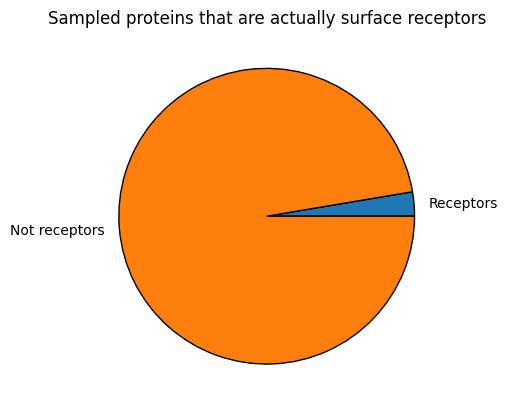

In [14]:
# filter out atlas surface proteins that are not receptors
atlas_receptors = cell_surf_prot_sheet[cell_surf_prot_sheet["UP_Protein_name"].str.contains("receptor", case=False)].reset_index(drop=True) #count = 242

# receptors that are both in sample and in surface proteome atlas
actual_receptors = pd.merge(potential_receptors, atlas_receptors, how="inner", left_on=0, right_on="ID_link")
print(f'Actual receptors: {actual_receptors.shape[0]}')

labels = 'Receptors', 'Not receptors'
sizes = [actual_receptors.shape[0], potential_receptors.shape[0] - actual_receptors.shape[0]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, wedgeprops={'edgecolor': 'black'})
plt.title("Sampled proteins that are actually surface receptors")

In [15]:
# filter STRING data and tt predictions to only contain pairs with actual receptors
tt_pred_actual_receptors = tt_predictions.merge(actual_receptors[["ID_link"]], left_on='receptor', right_on='ID_link')
# only consider positive tt predictions, greater that 0.5 is default
tt_pred_actual_receptors = tt_pred_actual_receptors[tt_pred_actual_receptors["tt_score"] > 0.5]

# returns true if either prot1 or prot2 are an actual receptor protein
def pair_contains_actual_receptor(row):
    return row["prot1"] in set(actual_receptors["ID_link"]) or row["prot2"] in set(actual_receptors["ID_link"])

# filter out non receptors from STRING PPI data and alphafold data
STRING_data_actual_receptors = STRING_data[STRING_data.apply(pair_contains_actual_receptor, axis=1)]
alphafold_receptors = alphafold[alphafold.apply(pair_contains_actual_receptor, axis=1)]

# order dfs alphanumerically for easy protein pair matching (ie, some entries are L-R while others are R-L)
tt_pred_actual_receptors_AN = pd.DataFrame({
    "prot1": tt_pred_actual_receptors[["receptor", "ligand"]].min(axis=1),
    "prot2": tt_pred_actual_receptors[["receptor", "ligand"]].max(axis=1),
    "tt_score": tt_pred_actual_receptors["tt_score"]
})

STRING_data_actual_receptors_AN = pd.DataFrame({
    "prot1": STRING_data_actual_receptors[["prot1", "prot2"]].min(axis=1),
    "prot2": STRING_data_actual_receptors[["prot1", "prot2"]].max(axis=1),
    "tt_score": STRING_data_actual_receptors["tt_score"],
    "string_score": STRING_data_actual_receptors["string_score"]
})

alphafold_receptors_AN = pd.DataFrame({
    "prot1": alphafold_receptors[["prot1", "prot2"]].min(axis=1),
    "prot2": alphafold_receptors[["prot1", "prot2"]].max(axis=1),
    "iPTM score": alphafold_receptors["iPTM score"]
})

# merge alphafold pairs with tt pairs
alpha_tt_receptors = pd.merge(tt_pred_actual_receptors_AN, alphafold_receptors_AN, how="left", left_on=["prot1", "prot2"], right_on=["prot1", "prot2"])

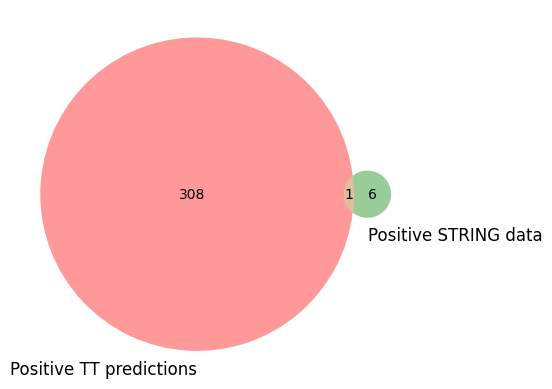

In [16]:
from matplotlib_venn import venn2

# Use the venn2 function
venn2(subsets = (tt_pred_actual_receptors.shape[0], # objects in set A
                 STRING_data_actual_receptors.shape[0], # objects in set B
                 STRING_data_actual_receptors[STRING_data_actual_receptors["tt_score"] > 0.5].shape[0]), # objects in set A and B
      set_labels = ('Positive TT predictions', 'Positive STRING data'))
plt.show()

In [17]:
alpha_tt_receptors.sort_values(by="tt_score", ascending=False, inplace=True)
alpha_tt_receptors.reset_index(drop=True, inplace=True)
#alpha_tt_receptors.sort_values(by="iPTM score", ascending=False)[0:85]
alpha_tt_receptors[116:216].to_csv("../alphafold/to_json/SP_alpha_tt_receptors_116:216.csv")

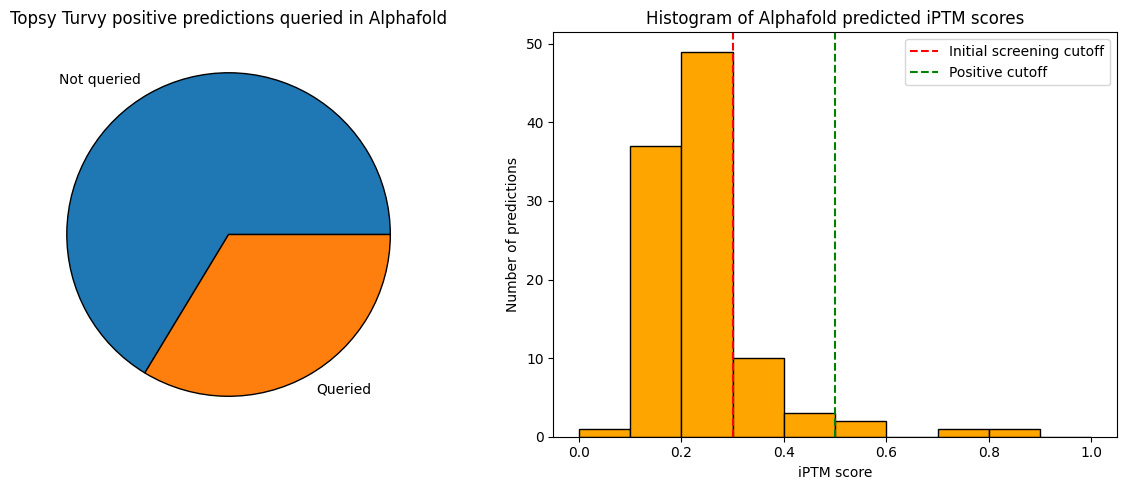

In [20]:
# Visualizations for alphafold queries of positive topsy turvy predicitons

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
labels = ['Not queried', 'Queried']
sizes = [alpha_tt_receptors["iPTM score"].isna().sum(), alpha_tt_receptors.shape[0] - alpha_tt_receptors["iPTM score"].isna().sum()]
ax[0].pie(sizes, labels=labels, wedgeprops={'edgecolor': 'black'})
ax[0].set_title("Topsy Turvy positive predictions queried in Alphafold")

# Second subplot
bins = np.arange(0, 1.1, 0.1)
ax[1].hist(alpha_tt_receptors["iPTM score"][alpha_tt_receptors["iPTM score"].isna()==False], bins=bins, edgecolor="black", color="orange")
ax[1].axvline(x=0.3, color='red', linestyle='--', label="Initial screening cutoff")
ax[1].axvline(x=0.5, color='green', linestyle='--', label="Positive cutoff")
ax[1].set_xlabel("iPTM score")
ax[1].set_ylabel("Number of predictions")
ax[1].set_title("Histogram of Alphafold predicted iPTM scores")
plt.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [19]:
#Code for making pairs tsv file for only actual receptors
'''
set1 = set(actual_receptors["ID_link"])
set2 = set(ligands[0])

with open('../TUnA/data/raw/xspecies/pairs/mouse_PPIs.tsv', 'w') as file:
    # Iterate through all elements of set1 and set2
    for elem1 in set1:
        for elem2 in set2:
            # Write each pair as tab-separated values on a new line
            file.write(f"{elem1}\t{elem2}\t0.0\n")

print("File created successfully.")
'''

'\nset1 = set(actual_receptors["ID_link"])\nset2 = set(ligands[0])\n\nwith open(\'../TUnA/data/raw/xspecies/pairs/mouse_PPIs.tsv\', \'w\') as file:\n    # Iterate through all elements of set1 and set2\n    for elem1 in set1:\n        for elem2 in set2:\n            # Write each pair as tab-separated values on a new line\n            file.write(f"{elem1}\t{elem2}\t0.0\n")\n\nprint("File created successfully.")\n'